In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

%matplotlib inline

!pip install facenet-pytorch

In [3]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/course_work')

In [4]:
!cp /content/drive/MyDrive/facial_analysis_for_colab.py .

In [5]:
from facial_analysis_for_colab import FacialImageProcessing
imgProcessing=FacialImageProcessing(False)

In [6]:
import torch
from PIL import Image
from torchvision import transforms
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = 'cuda' if use_cuda else 'cpu'

True


In [10]:
USE_ENET2=True
NUM_EMOTIONS=8 #7 #
if NUM_EMOTIONS==7:
    idx_to_class={0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}
else:
    idx_to_class={0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}
if USE_ENET2:
    IMG_SIZE=260
    if NUM_EMOTIONS==7: # 7 emotions
        PATH='../models/affectnet_emotions/enet_b2_7.pt'
    else:
        PATH='/content/drive/MyDrive/models/enet_b2_8.pt'
else:
    IMG_SIZE=224
    if NUM_EMOTIONS==7: # 7 emotions from AFFECT_IMG_SEVEN_TRAIN_DATA_DIR and AFFECT_IMG_SEVEN_VAL_DATA_DIR
        PATH='../models/affectnet_emotions/enet_b0_7.pt'
    else:
        #PATH='../models/affectnet_emotions/enet_b0_8_best_vgaf.pt'
        PATH='../models/affectnet_emotions/enet_b0_8_best_afew.pt'

In [7]:
IMG_SIZE=260
idx_to_class={0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}
PATH='/content/drive/MyDrive/models/enet_b2_8.pt'

In [8]:
!pip install timm==0.4.5

In [9]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
model = torch.load(PATH)
model=model.to(device)
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv(


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


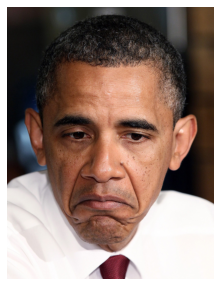

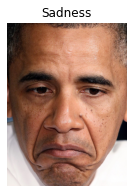

In [10]:
fpath='/content/drive/MyDrive/data/sad_face.jpg'
frame_bgr=cv2.imread(fpath)
plt.figure(figsize=(5, 5))
frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(frame)
bounding_boxes, points = imgProcessing.detect_faces(frame)
points = points.T
for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    face_img=frame[y1:y2,x1:x2,:]
    
    img_tensor = test_transforms(Image.fromarray(face_img))
    img_tensor.unsqueeze_(0)
    scores = model(img_tensor.to(device))
    scores=scores[0].data.cpu().numpy()
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(face_img)
    plt.title(idx_to_class[np.argmax(scores)])

In [11]:
!pip install grad-cam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


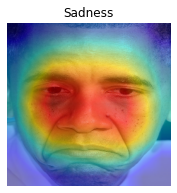

In [12]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
target_layers = [model.blocks[-1][-1]]
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)

for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    face_img=frame[y1:y2,x1:x2,:]
    
    img_tensor = test_transforms(Image.fromarray(face_img))
    img_tensor.unsqueeze_(0)
    scores = model(img_tensor.to(device))
    scores=scores[0].data.cpu().numpy()
    grayscale_cam = cam(input_tensor=img_tensor)
    grayscale_cam = grayscale_cam[0, :]
    face_img=cv2.resize(face_img,(IMG_SIZE,IMG_SIZE))
    rgb_img = np.float32(face_img) / 255
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(visualization)
    plt.title(idx_to_class[np.argmax(scores)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


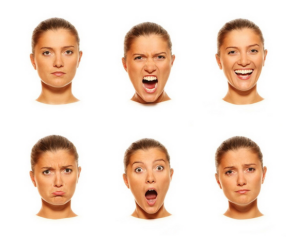

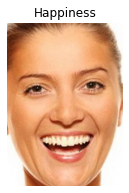

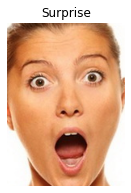

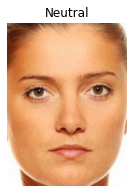

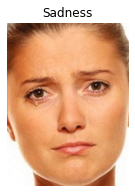

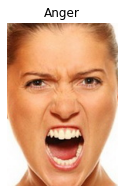

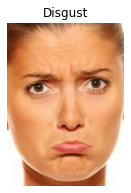

In [18]:
fpath='/content/drive/MyDrive/data/many emotions.jpg'
frame_bgr=cv2.imread(fpath)
plt.figure(figsize=(5, 5))
frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(frame)
bounding_boxes, points = imgProcessing.detect_faces(frame)
points = points.T
for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    face_img=frame[y1:y2,x1:x2,:]
    
    img_tensor = test_transforms(Image.fromarray(face_img))
    img_tensor.unsqueeze_(0)
    scores = model(img_tensor.to(device))
    scores=scores[0].data.cpu().numpy()
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(face_img)
    plt.title(idx_to_class[np.argmax(scores)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


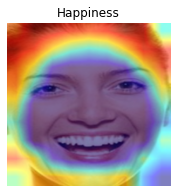

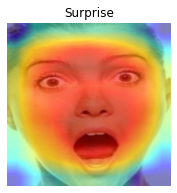

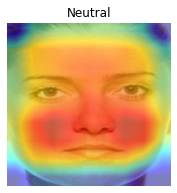

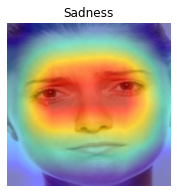

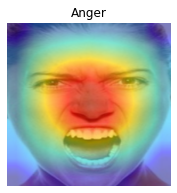

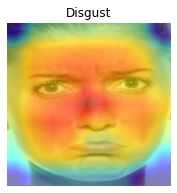

In [19]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
target_layers = [model.blocks[-1][-1]]
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)

for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    face_img=frame[y1:y2,x1:x2,:]
    
    img_tensor = test_transforms(Image.fromarray(face_img))
    img_tensor.unsqueeze_(0)
    scores = model(img_tensor.to(device))
    scores=scores[0].data.cpu().numpy()
    grayscale_cam = cam(input_tensor=img_tensor)
    grayscale_cam = grayscale_cam[0, :]
    face_img=cv2.resize(face_img,(IMG_SIZE,IMG_SIZE))
    rgb_img = np.float32(face_img) / 255
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(visualization)
    plt.title(idx_to_class[np.argmax(scores)])

In [20]:
imgProcessing.close()